# PARTE A: Linear Regression From Scratch

## PASO 1

In [40]:
# IMPORTACIÓN DE LIBRERÍAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
# CARGA DE DATOS
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")

In [42]:
# TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# ESTANDARIZACIÓN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PASO 2

In [44]:
# AGREGACIÓN DE UNA COLUMNA
X_train_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]


In [45]:
# IMPLEMENTACIÓN MCO CERRADA
beta_hat = np.linalg.inv(X_train_bias.T @ X_train_bias) @ (X_train_bias.T @ y_train)

intercept_ols = beta_hat[0]
coef_ols = beta_hat[1:]

print("Intercepto:", intercept_ols)
print("Coeficientes:", coef_ols)

Intercepto: 2.07194693737888
Coeficientes: [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]


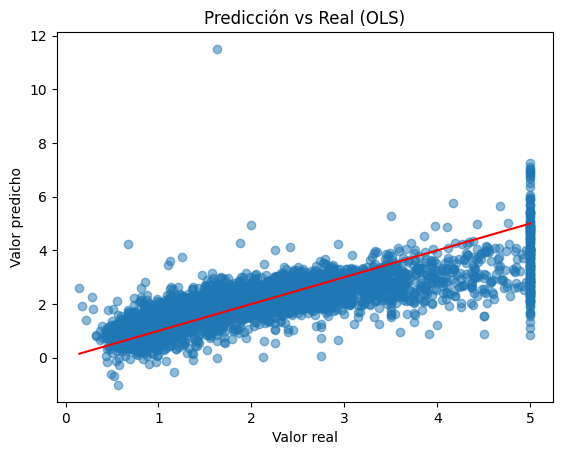

MSE (OLS): 0.5559, R2: 0.5758


In [46]:
# PREDICCIONES
y_pred_ols = X_test_bias @ beta_hat

plt.scatter(y_test, y_pred_ols, alpha=0.5)
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicción vs Real (OLS)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.show()


# MÉTRICAS
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print(f"MSE (OLS): {mse_ols:.4f}, R2: {r2_ols:.4f}")

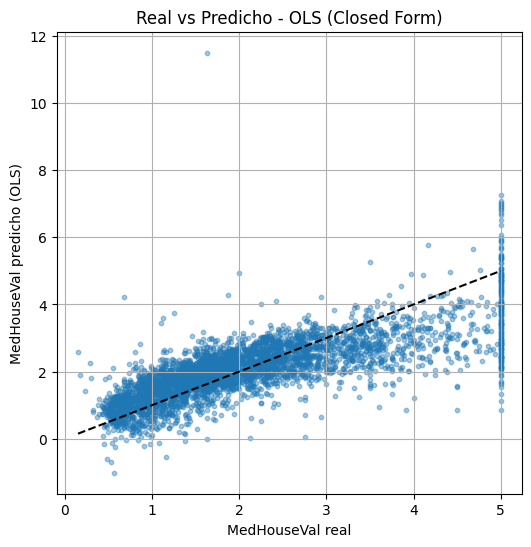

In [47]:
# GRÁFICO (REAL VS PREDICHO)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("MedHouseVal real")
plt.ylabel("MedHouseVal predicho (OLS)")
plt.title("Real vs Predicho - OLS (Closed Form)")
plt.grid()
plt.show()

# PASO 3

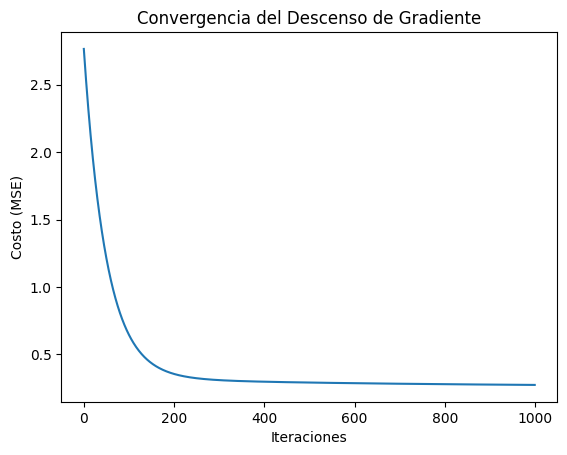

In [48]:
# DESCENSO DE GRADIENTE

# Inicializar parámetros
m = X_train_bias.shape[0]
beta = np.zeros((X_train_bias.shape[1], 1))
y_train_vector = y_train.values.reshape(-1, 1)

# Hiperparámetros
learning_rate = 0.01
n_iterations = 1000

cost_history = []

for i in range(n_iterations):
    gradients = (1/m) * X_train_bias.T @ (X_train_bias @ beta - y_train_vector)
    beta = beta - learning_rate * gradients
    cost = (1/(2*m)) * np.sum((X_train_bias @ beta - y_train_vector) ** 2)
    cost_history.append(cost)

plt.plot(range(n_iterations), cost_history)
plt.xlabel("Iteraciones")
plt.ylabel("Costo (MSE)")
plt.title("Convergencia del Descenso de Gradiente")
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURACIÓN INICIAL
m = X_train_bias.shape[0]
y_train_vector = y_train.values.reshape(-1, 1)

def gradient_descent(X, y, learning_rate, n_iterations):
    m = X.shape[0]
    beta = np.zeros((X.shape[1], 1))
    cost_history = []
    
    for i in range(n_iterations):
        # Calcular gradiente: (1/m) * X^T (Xβ - y)
        gradients = (1/m) * X.T @ (X @ beta - y)
        beta = beta - learning_rate * gradients
        
        # Calcular costo en cada iteración
        cost = (1/(2*m)) * np.sum((X @ beta - y) ** 2)
        cost_history.append(cost)
    
    return beta, cost_history

Con learning rate=0.01, beta final (primeros 3 coef): [2.05833325 0.79130506 0.19523899]
Con learning rate=0.1, beta final (primeros 3 coef): [2.07194694 0.8625104  0.1264225 ]


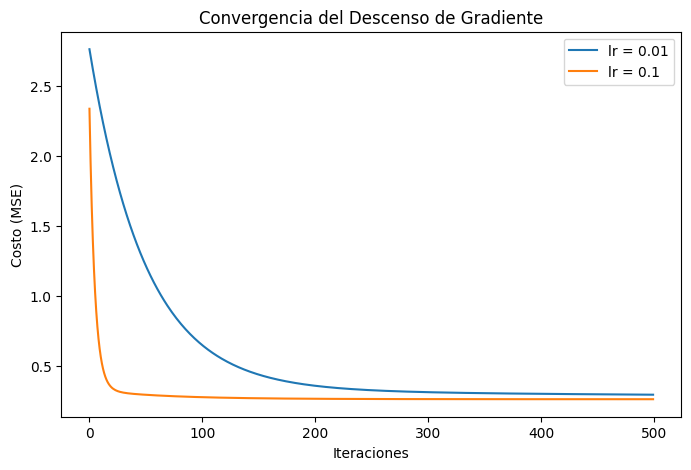

In [50]:
# PRUEBA CON DOS TASAS DE APRENDIZAJE
learning_rates = [0.01, 0.1]  # Una conservadora y otra más agresiva
n_iterations = 500

plt.figure(figsize=(8, 5))

for lr in learning_rates:
    beta_gd, cost_history = gradient_descent(X_train_bias, y_train_vector, lr, n_iterations)
    plt.plot(cost_history, label=f"lr = {lr}")
    print(f"Con learning rate={lr}, beta final (primeros 3 coef): {beta_gd[:3].flatten()}")

plt.xlabel("Iteraciones")
plt.ylabel("Costo (MSE)")
plt.title("Convergencia del Descenso de Gradiente")
plt.legend()
plt.show()


In [51]:
# USAR SOLO 1 CARACTERÍSTICA + INTERCEPTO PARA PODER GRAFICAR EN 2D 
X1 = X_train_scaled[:, 0].reshape(-1, 1)  # Primera característica
X1_bias = np.c_[np.ones((X1.shape[0], 1)), X1]  # Columna de 1s
y1 = y_train.values.reshape(-1, 1)

# DEFINICIÓN DE COSTO 
def cost_function(beta):
    return (1/(2*len(X1_bias))) * np.sum((X1_bias @ beta - y1)**2)

def gradient(beta):
    return (1/len(X1_bias)) * X1_bias.T @ (X1_bias @ beta - y1)

# CREAR MALLA DE β0 y β1
beta0_range = np.linspace(-1, 3, 50)
beta1_range = np.linspace(-2, 2, 50)

J_grid = np.zeros((len(beta1_range), len(beta0_range)))

for i, b0 in enumerate(beta0_range):
    for j, b1 in enumerate(beta1_range):
        b = np.array([[b0], [b1]])
        J_grid[j, i] = cost_function(b)

B0, B1 = np.meshgrid(beta0_range, beta1_range)

In [52]:
# DESCENSO DE GRADIENTE Y REGISTRO DE PUNTOS 
beta = np.array([[0.0], [0.0]])  # inicialización
step_size = 0.1
convergence_threshold = 1e-3

opt_pts = [beta.flatten()]
opt_grads = []

for i in range(50):  # limitar iteraciones para visualización
    grad = gradient(beta)
    beta = beta - step_size * grad
    opt_pts.append(beta.flatten())
    opt_grads.append(grad.flatten())
    if np.linalg.norm(grad) < convergence_threshold:
        break

opt_pts = np.array(opt_pts)
opt_grads = np.array(opt_grads)


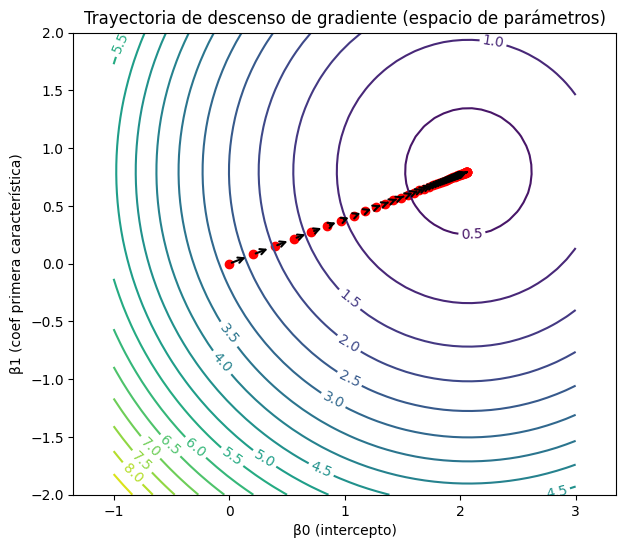

In [53]:
# GRAFICAR CURVAS DE NIVEL Y TRAYECTORIA
plt.figure(figsize=(7, 6))
contours = plt.contour(B0, B1, J_grid, levels=20, cmap="viridis")
plt.clabel(contours)
plt.scatter(opt_pts[:, 0], opt_pts[:, 1], color='red')

for opt_pt, opt_grad in zip(opt_pts, opt_grads):
    plt.annotate('', xytext=(opt_pt[0], opt_pt[1]),
                 xy=(opt_pt[0]-0.8*step_size*opt_grad[0],
                     opt_pt[1]-0.8*step_size*opt_grad[1]),
                 arrowprops={'arrowstyle': '->', 'lw': 1.5}, va='center', ha='center')

plt.xlabel("β0 (intercepto)")
plt.ylabel("β1 (coef primera característica)")
plt.title("Trayectoria de descenso de gradiente (espacio de parámetros)")
plt.axis('equal')
plt.show()

In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# CONVERSIÓN DE ARRAYS
beta_ols = np.atleast_2d(beta_hat).reshape(-1,1)
beta_gd  = np.atleast_2d(beta_gd).reshape(-1,1)

# Predicciones en test 
y_pred_ols = X_test_bias @ beta_ols
y_pred_gd  = X_test_bias @ beta_gd

# --- Errores y R^2 ---
mse_ols = mean_squared_error(y_test.values.reshape(-1,1), y_pred_ols)
mse_gd  = mean_squared_error(y_test.values.reshape(-1,1), y_pred_gd)
r2_ols  = r2_score(y_test.values.reshape(-1,1), y_pred_ols)
r2_gd   = r2_score(y_test.values.reshape(-1,1), y_pred_gd)

print("=== Errores en test ===")
print(f"MSE OLS cerrado: {mse_ols:.6f}")
print(f"MSE GD         : {mse_gd:.6f}")
print()
print("=== R^2 en test ===")
print(f"R2 OLS cerrado: {r2_ols:.6f}")
print(f"R2 GD         : {r2_gd:.6f}")


=== Errores en test ===
MSE OLS cerrado: 0.555892
MSE GD         : 0.556193

=== R^2 en test ===
R2 OLS cerrado: 0.575788
R2 GD         : 0.575557


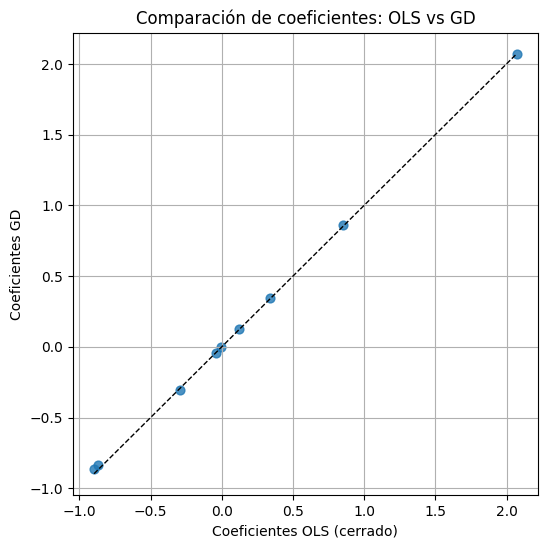

In [55]:
# Scatter — Coeficientes OLS vs GD
plt.figure(figsize=(6,6))
plt.scatter(beta_ols.flatten(), beta_gd.flatten(), s=40, alpha=0.8)
maxv = max(np.max(beta_ols), np.max(beta_gd))
minv = min(np.min(beta_ols), np.min(beta_gd))
plt.plot([minv, maxv], [minv, maxv], 'k--', lw=1)
plt.xlabel("Coeficientes OLS (cerrado)")
plt.ylabel("Coeficientes GD")
plt.title("Comparación de coeficientes: OLS vs GD")
plt.grid(True)
plt.show()

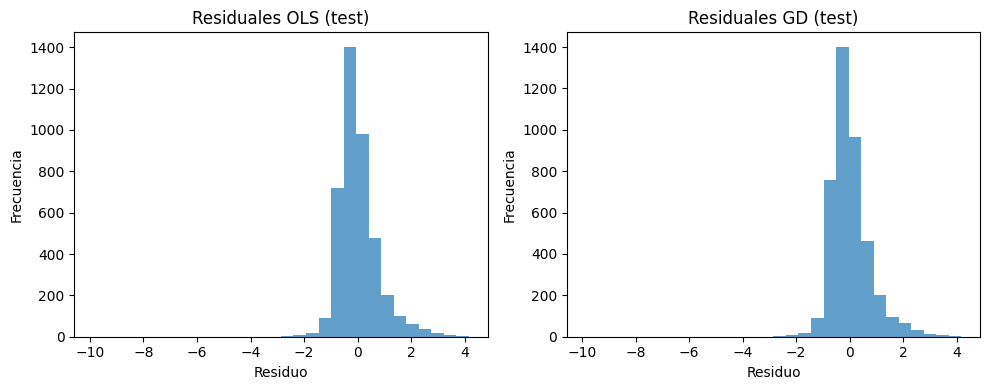

In [56]:
# Residuals (test): distribución y comparación
res_ols = (y_test.values.reshape(-1,1) - y_pred_ols).flatten()
res_gd  = (y_test.values.reshape(-1,1) - y_pred_gd ).flatten()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(res_ols, bins=30, alpha=0.7)
plt.title("Residuales OLS (test)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(res_gd, bins=30, alpha=0.7)
plt.title("Residuales GD (test)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


# PARTE B: Scikit-learn Linear Models

In [57]:
# ==== Parte B: Scikit-learn Linear Models (Baseline) ====
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- utilidades para reutilizar variables de la Parte A ---
def first_defined(names, scope):
    for n in names:
        if n in scope:
            return scope[n]
    return None

def strip_bias(X):
    """Si X tiene una columna constante (p.ej., de unos), la elimina."""
    if X is None:
        return None
    X = np.asarray(X)
    # constante si var≈0 y valor medio≈1 o ≈0 (por seguridad)
    for j in range(X.shape[1]):
        col = X[:, j]
        if np.isclose(col.var(), 0.0) and (np.isclose(col.mean(), 1.0) or np.isclose(col.mean(), 0.0)):
            return np.delete(X, j, axis=1)
    return X

# Intentar recuperar conjuntos ya creados en la Parte A
X_train_std = first_defined(['X_train_std','X_train_scaled','Xtr_std','X_train_z'], globals())
X_test_std  = first_defined(['X_test_std','X_test_scaled','Xte_std','X_test_z'], globals())
X_train_raw = first_defined(['X_train','Xtr'], globals())
X_test_raw  = first_defined(['X_test','Xte'], globals())
y_train     = first_defined(['y_train','ytr','y_tr'], globals())
y_test      = first_defined(['y_test','yte','y_te'], globals())
beta_ols    = first_defined(['beta_ols','beta_hat','beta_closed_form','beta_cf'], globals())

# Si no hay estandarizadas, usar raw y estandarizar aquí (sin fuga de info)
if X_train_std is None or X_test_std is None:
    scaler = StandardScaler()
    if X_train_raw is None or X_test_raw is None:
        raise RuntimeError("No encuentro X_train/X_test ni sus versiones estandarizadas. Asegúrate de ejecutar la Parte A primero.")
    X_train_std = scaler.fit_transform(np.asarray(X_train_raw))
    X_test_std  = scaler.transform(np.asarray(X_test_raw))

# Quitar columna de sesgo si tu Parte A la agregó
X_train_used = strip_bias(X_train_std)
X_test_used  = strip_bias(X_test_std)

# --- Ajuste con scikit-learn ---
lin = LinearRegression(fit_intercept=True)
lin.fit(X_train_used, np.asarray(y_train).ravel())

# Predicciones y métricas en test
y_pred_test = lin.predict(X_test_used)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("=== Baseline con scikit-learn ===")
print(f"Intercept (sklearn): {lin.intercept_:.6f}")
print(f"MSE test: {mse_test:.6f}")
print(f"R^2  test: {r2_test:.6f}")

# --- Comparación con tu OLS de la Parte A (si está disponible) ---
def compare_with_ols(beta_ols, model, X_used):
    beta_ols = np.asarray(beta_ols).reshape(-1)
    # Si tu OLS incluye sesgo, separar
    if beta_ols.size == X_used.shape[1] + 1:
        b0_ols = beta_ols[0]
        w_ols = beta_ols[1:]
    else:
        b0_ols = 0.0
        w_ols = beta_ols
    coef_diff = np.abs(w_ols - model.coef_.ravel())
    b0_diff = abs(b0_ols - model.intercept_)
    print("\n=== Comparación coeficientes OLS (Parte A) vs. sklearn ===")
    print(f"Max |diff| coeficientes: {coef_diff.max():.6e}")
    print(f"|diff| intercepto:      {b0_diff:.6e}")

if beta_ols is not None:
    compare_with_ols(beta_ols, lin, X_train_used)
else:
    print("\n(No se encontró 'beta_ols' de la Parte A; se omite la comparación automática.)")


=== Baseline con scikit-learn ===
Intercept (sklearn): 2.071947
MSE test: 0.555892
R^2  test: 0.575788

=== Comparación coeficientes OLS (Parte A) vs. sklearn ===
Max |diff| coeficientes: 4.440892e-15
|diff| intercepto:      8.881784e-16


# PARTE C: Regularization and Hyperparameter Choice

# PARTE D: Bike Rentals